In [1]:
import pandas as pd
from GIANA4 import *
import numpy as np
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os, re
from os import path
import numpy as np
from copy import deepcopy
from Bio.Align import substitution_matrices
import time
from time import gmtime, strftime
from operator import itemgetter
from itertools import chain
from random import shuffle
from optparse import OptionParser
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import faiss
from query import *
from sklearn.metrics import pairwise_distances
from Levenshtein import distance as levenshtein_distance

data = pd.read_csv('vdjdb_cleaned.csv')

e:\Anaconda\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [2]:
# 确保输出目录存在
output_dir = './distance_result'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 调用 GIANA 脚本
subprocess.run(['python', 'GIANA4.py', '-f', './vdjdb_cleaned.csv', '-o', output_dir, '-t', '7'])

CompletedProcess(args=['python', 'GIANA4.py', '-f', './vdjdb_cleaned.csv', '-o', './distance_result', '-t', '7'], returncode=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29762 entries, 0 to 29761
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   complex.id       29762 non-null  int64 
 1   cdr3_alpha       29762 non-null  object
 2   v.segm_alpha     29762 non-null  object
 3   j.segm_alpha     29762 non-null  object
 4   species          29762 non-null  object
 5   mhc.a            29762 non-null  object
 6   mhc.b            29762 non-null  object
 7   mhc.class        29762 non-null  object
 8   antigen.epitope  29762 non-null  object
 9   cdr3_beta        29762 non-null  object
 10  v.segm_beta      29762 non-null  object
 11  j.segm_beta      29762 non-null  object
dtypes: int64(1), object(11)
memory usage: 2.7+ MB


In [4]:
# 筛选出阿尔法链和贝塔链数据
alpha_data = data[['complex.id', 'cdr3_alpha', 'v.segm_alpha', 'j.segm_alpha', 'species', 'mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope']]
beta_data = data[['complex.id', 'cdr3_beta', 'v.segm_beta', 'j.segm_beta', 'species', 'mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope']]
cdr3_alpha_beta = data[['complex.id', 'cdr3_alpha','cdr3_beta', 'v.segm_beta', 'j.segm_beta', 'species', 'mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope']]
# 保存阿尔法链和贝塔链数据为独立的 CSV 文件
alpha_data.to_csv('alpha_chain_data.csv', index=False)
beta_data.to_csv('beta_chain_data.csv', index=False)
cdr3_alpha_beta.to_csv('cdr3_alpha_beta.csv', index=False)

# 设置输出目录
output_dir_alpha = './alpha_distance_result'
output_dir_beta = './beta_distance_result'
output_dir_alpha_beta = './alpha_beta_distance_result'

In [5]:
# 运行 GIANA 脚本计算阿尔法链的距离和相似度矩阵
subprocess.run(['python', 'GIANA4.py', '-f', './alpha_chain_data.csv', '-o', output_dir_alpha, '-t', '7'])

# 运行 GIANA 脚本计算贝塔链的距离和相似度矩阵
subprocess.run(['python', 'GIANA4.py', '-f', './beta_chain_data.csv', '-o', output_dir_beta, '-t', '7'])


CompletedProcess(args=['python', 'GIANA4.py', '-f', './beta_chain_data.csv', '-o', './beta_distance_result', '-t', '7'], returncode=1)

In [6]:
# 查看数据的前几行
print(alpha_data.head())
print(beta_data.head())

   complex.id      cdr3_alpha     v.segm_alpha j.segm_alpha      species  \
0           1   CIVRAPGRADMRF      TRAV26-1*01    TRAJ43*01  HomoSapiens   
1           2  CAVPSGAGSYQLTF        TRAV20*01    TRAJ28*01  HomoSapiens   
2           4   CAYRPPGTYKYIF  TRAV38-2/DV8*01    TRAJ40*01  HomoSapiens   
3           5   CIVRAPGRADMRF      TRAV26-1*01    TRAJ43*01  HomoSapiens   
4           6  CAVPSGAGSYQLTF        TRAV20*01    TRAJ28*01  HomoSapiens   

      mhc.a mhc.b mhc.class antigen.epitope  
0  HLA-B*08   B2M      MHCI        FLKEKGGL  
1  HLA-B*08   B2M      MHCI        FLKEKGGL  
2  HLA-B*08   B2M      MHCI        FLKEKGGL  
3  HLA-B*08   B2M      MHCI        FLKEQGGL  
4  HLA-B*08   B2M      MHCI        FLKEQGGL  
   complex.id             cdr3_beta v.segm_beta j.segm_beta      species  \
0           1  CASSYLPGQGDHYSNQPQHF   TRBV13*01  TRBJ1-5*01  HomoSapiens   
1           2   CASSFEPGQGFYSNQPQHF   TRBV13*01  TRBJ1-5*01  HomoSapiens   
2           4        CASSALASLNEQFF   T

In [13]:
# Load your data
alpha_chain_data = pd.read_csv('alpha_chain_data.csv')
beta_chain_data = pd.read_csv('beta_chain_data.csv')

# Extract CDR3 sequences and use only the first 100
alpha_cdr3_sequences = alpha_chain_data['cdr3_alpha'].tolist()
beta_cdr3_sequences = beta_chain_data['cdr3_beta'].tolist()

# Function to calculate the pairwise Levenshtein distance matrix
def levenshtein_distance_matrix(sequences):
    length = len(sequences)
    dist_matrix = np.zeros((length, length))
    for i in range(length):
        for j in range(i + 1, length):  # Use symmetry to save computation
            dist = levenshtein_distance(sequences[i], sequences[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

# Compute the distance matrices
alpha_distance_matrix = levenshtein_distance_matrix(alpha_cdr3_sequences)
beta_distance_matrix = levenshtein_distance_matrix(beta_cdr3_sequences)

# Optionally, save the matrices to CSV files
np.savetxt("alpha_distance_matrix.csv", alpha_distance_matrix, delimiter=",")
np.savetxt("beta_distance_matrix.csv", beta_distance_matrix, delimiter=",")

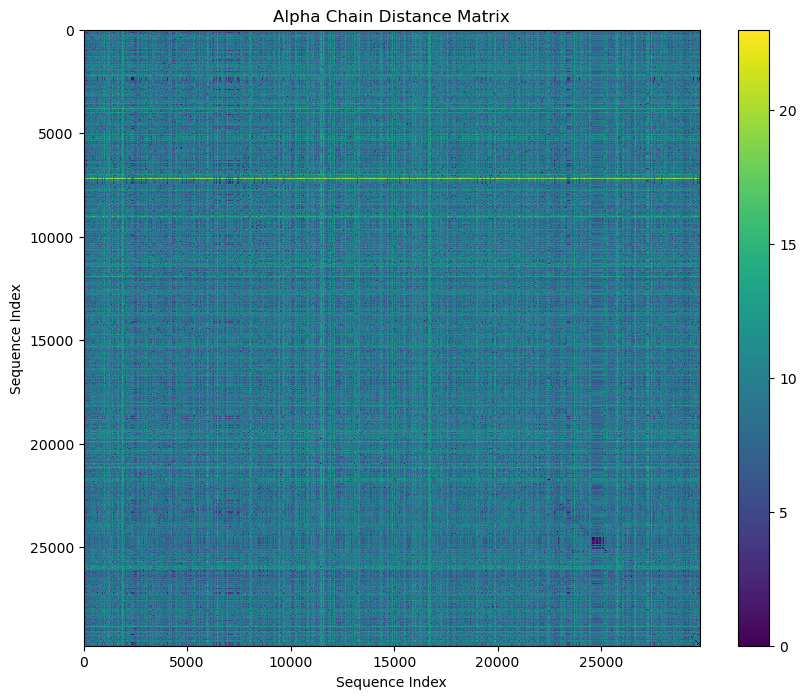

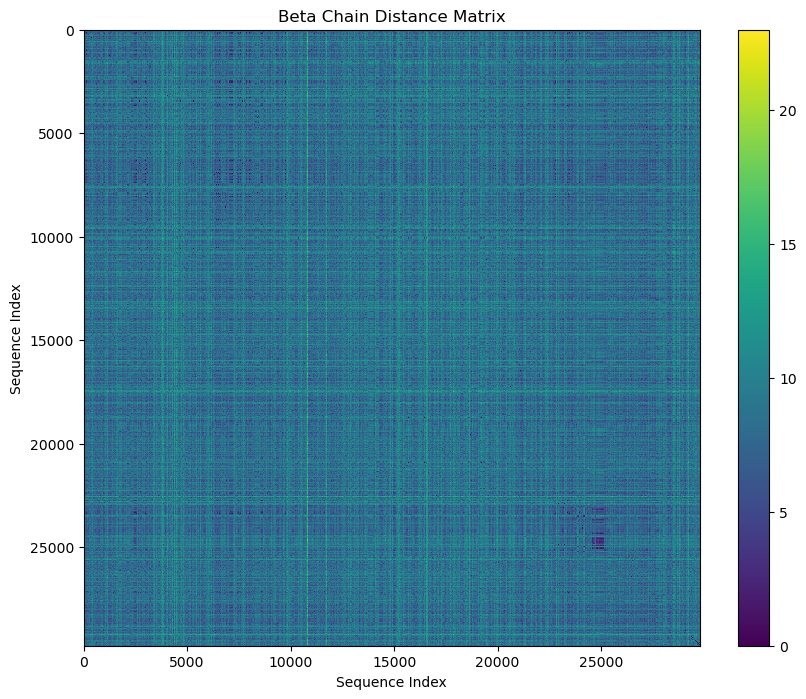

In [14]:
# Load the distance matrices from CSV files
alpha_distance_matrix = pd.read_csv("alpha_distance_matrix.csv", delimiter=",")
beta_distance_matrix = pd.read_csv("beta_distance_matrix.csv", delimiter=",")

# Function to plot a distance matrix
def plot_distance_matrix(dist_matrix, title="Distance Matrix"):
    plt.figure(figsize=(10, 8))
    plt.imshow(dist_matrix, interpolation='nearest', cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Sequence Index")
    plt.ylabel("Sequence Index")
    plt.grid(False)
    plt.show()

# Plot the alpha and beta chain distance matrices
plot_distance_matrix(alpha_distance_matrix, title="Alpha Chain Distance Matrix")
plot_distance_matrix(beta_distance_matrix, title="Beta Chain Distance Matrix")
